# Notebook for QC metrics from single-cell Multiome datasets

- last updated: 06/13/2024

We want to generate plots for different QC metrics from sc-Multiome datasets. The QC metrics that we'll focus on are as follows:

### RNA -> moved to a python notebook
- number of genes/cell
- number of counts/cell
- % mitochondrial counts/cell

### ATAC -> moved a python notebook, except some Signac/R specific analyses
- number of fragments/cell
- TSS enrichment/cell
- TSS enrichment vs distance from TSS
- fragment size distribution



In [1]:
library(Seurat)
library(Signac)
library(patchwork)
library(ggplot2)

# require(cowplot); require(stringr); require(data.table); set.seed(123)
# require(glmnet); theme_set(theme_cowplot()); require(gganimate)
# require(RColorBrewer); require(patchwork)

Attaching SeuratObject



In [4]:
# Load the plotting module
source("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/scripts/utils/module_coverage_plot_viz.R")

In [2]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/QC_metrics/"
figpath

[1] "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/QC_metrics/"

In [3]:
# import the Seurat object
multiome <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_wnn_gene_activity_3d_umaps.rds")
multiome

An object of class Seurat 
726063 features across 95196 samples within 5 assays 
Active assay: peaks_integrated (640834 features, 0 variable features)
 4 other assays present: RNA, SCT, integrated, Gene.Activity
 9 dimensional reductions calculated: integrated_lsi, umap, integrated_pca, umap.rna, umap.atac, wnn.umap, umap.rna.3D, umap.atac.3D, wnn.umap.3D

In [ ]:
# List of assays to keep
assaysToKeep <- c("peaks_integrated", "integrated","RNA","SCT","Gene.Activity")

# Function to remove other assays from a Seurat object
remove_unwanted_assays <- function(seuratObject, assaysToKeep) {
  allAssays <- names(seuratObject@assays)
  assaysToRemove <- setdiff(allAssays, assaysToKeep)
  
  for (assay in assaysToRemove) {
    seuratObject[[assay]] <- NULL
  }
  
  return(seuratObject)
}

# Apply the function to each of your Seurat objects
multiome <- remove_unwanted_assays(multiome, assaysToKeep)

In [72]:
table(multiome$dataset)
table(multiome$timepoint)


TDR118 TDR119 TDR124 TDR125 TDR126 TDR127 TDR128 
 13614  12487   6610  17273  15036  19138  11038 

In [11]:
# filter out "low_quality_cells"
multiome <- subset(multiome, subset = annotation_ML_coarse != "low_quality_cells")


In [64]:
# Function to check if a fragment object is non-empty
is_non_empty_fragment <- function(frag) {
  return(!is.null(frag) && length(frag@cells) > 0)
}

# Identify non-empty Fragment objects
non_empty_fragments <- lapply(fragments_list, function(frag) {
  if (is_non_empty_fragment(frag)) {
    return(frag)
  } else {
    return(NULL)
  }
})
# non_empty_fragments

# Filter out the NULLs
non_empty_fragments <- Filter(Negate(is.null), non_empty_fragments)

non_empty_fragments

[[1]]
A Fragment object for 13568 cells

[[2]]
A Fragment object for 12413 cells

[[3]]
A Fragment object for 6528 cells

[[4]]
A Fragment object for 17130 cells

[[5]]
A Fragment object for 14970 cells

[[6]]
A Fragment object for 18963 cells

[[7]]
A Fragment object for 10990 cells


In [87]:
Fragments(multiome) <-NULL
Fragments(multiome) <- non_empty_fragments

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks_integrated_ to peaksintegrated_”


## Step 1. TSS enrichment vs distance from TSS (bp)

In [103]:
# NOTE that our gRanges object has the format of "1-start-end", not "chr1-start-end", so, we'd have to change the region argument
plot1 <- FragmentHistogram(multiome, group.by = "dataset", region = "1-1-20000000")

# Extract the ggplot object and modify it to remove fill color
plot1_modified <- plot1 +
  geom_density(aes(fill = NULL), position = "identity", alpha = 0.7, stat = "density") +
  theme_minimal() +
  labs(
    title = "Fragment Size Distribution",
    x = "Fragment length (bp)",
    y = "Count"
  ) +
  theme(legend.title = element_blank())

plot1_modified

ggsave(paste0(figpath, "hist_fragment_lengths_datasets_test.pdf"), plot = plot1_modified, width = 8, height = 12)


In [ ]:
# Modify the ggplot object to show density
plot1_modified <- plot1 +
  geom_density(aes(y = ..density.., color = dataset), size = 1, fill = NA) +  # Modify the plot to show density lines
  theme_minimal() +
  labs(
    title = "Fragment Size Distribution",
    x = "Fragment length (bp)",
    y = "Density"
  ) +
  theme(
    legend.title = element_blank(),
    legend.position = "bottom"
  )

# Display the modified plot
print(plot1_modified)

In [108]:
# Extract the ggplot object and modify it to remove fill color
plot1_modified <- plot1 +
  geom_density(aes(y = ..count.., fill = NULL), position = "identity", alpha = 0.7) +
  theme_minimal() +
  labs(
    title = "Fragment Size Distribution",
    x = "Fragment length (bp)",
    y = "Count"
  ) +
  theme(legend.title = element_blank())

ggsave(paste0(figpath, "hist_fragment_lengths_datasets_density.pdf"), plot = plot1_modified, width = 8, height = 6)


Warning message:
“Removed 100000 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 100000 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 14 rows containing missing values (`geom_bar()`).”


In [ ]:
plot1_modified

In [ ]:
# Modify the ggplot object to show only contours
plot1_modified <- plot1 +
  geom_density(aes(y = ..count.., color = dataset), fill = NA, size = 0.8) +  # fill = NA removes the fill color
  theme_minimal() +
  labs(
    title = "Fragment Size Distribution",
    x = "Fragment length (bp)",
    y = "Count"
  ) +
  theme(legend.title = element_blank())

Warning message:
“Removed 100000 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 14 rows containing missing values (`geom_bar()`).”


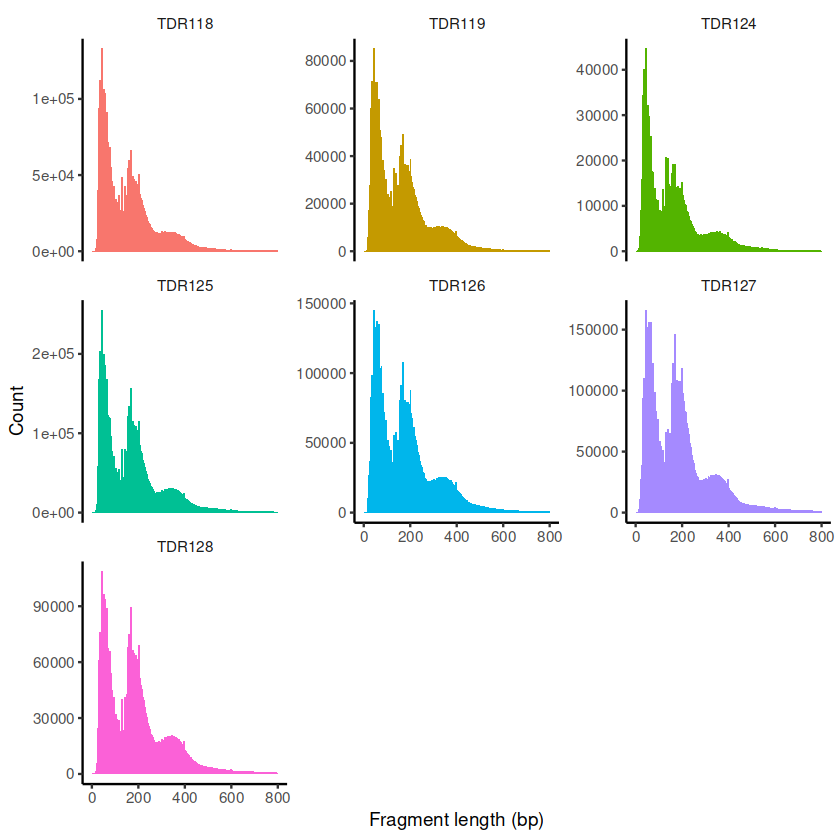

In [ ]:
plot1

Warning message:
“Removed 100000 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 100000 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 14 rows containing missing values (`geom_bar()`).”


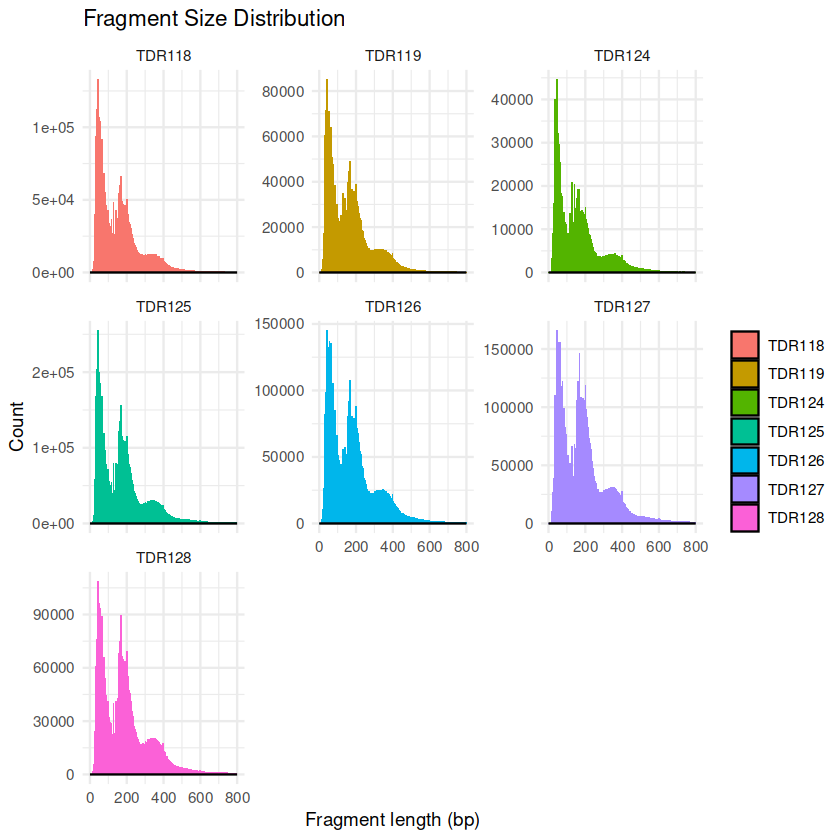

In [105]:
# Extract the ggplot object and modify it to remove fill color
plot1_modified <- plot1 +
  geom_density(aes(fill = NULL, group="dataset"), position = "identity", alpha = 0.7, stat = "density") +
  theme_minimal() +
  labs(
    title = "Fragment Size Distribution",
    x = "Fragment length (bp)",
    y = "Count"
  ) +
  theme(legend.title = element_blank())

plot1_modified

## [HOLD] An attempt to hack the Signac::FragmentHistogram function

In [124]:
FragmentHistogram_modified <- function(
  object,
  assay = NULL,
  region = "chr1-1-2000000",
  group.by = NULL,
  cells = NULL,
  log.scale = FALSE,
  ...
) {
  cells <- SetIfNull(x = cells, y = colnames(x = object))
  assay <- SetIfNull(x = assay, y = DefaultAssay(object = object))
  if (!inherits(x = object[[assay]], what = "ChromatinAssay")) {
    stop("The requested assay is not a ChromatinAssay.")
  }
  reads <- MultiGetReadsInRegion(
    object = object,
    assay = assay,
    region = region,
    cells = cells,
    verbose = FALSE,
    ...
  )
  # add group information
  if (is.null(x = group.by)) {
    groups <- Idents(object = object)
  } else {
    md <- object[[]]
    groups <- object[[group.by]]
    groups <- groups[, 1]
    names(x = groups) <- rownames(x = md)
  }
  reads$group <- groups[reads$cell]
  if (length(x = unique(x = reads$group)) == 1) {
    p <- ggplot(data = reads, aes(length)) +
      geom_histogram(bins = 200)
  } else {
    p <- ggplot(data = reads, mapping = aes(x = length, fill = NULL, line=group, stat = "density")) +
      geom_histogram(bins = 200) +
      facet_wrap(~group, scales = "free_y")
  }
  p <- p + xlim(c(0, 800)) +
    theme_classic() +
    theme(
      legend.position = "none",
      strip.background = element_blank()
    ) +
    xlab("Fragment length (bp)") +
    ylab("Count")
  if (log.scale) {
    p <- p + scale_y_log10()
  }
  # return(p)
    return(reads)
}

In [114]:
SetIfNull <- function(x, y) {
  if (is.null(x)) {
    return(y)
  } else {
    return(x)
  }
}

In [122]:
GetReadsInRegion <- function(cellmap, region, tabix.file, ...) {
  # Mock function to return a placeholder data.frame
  data.frame(
    length = runif(1000, min = 50, max = 800),
    cell = sample(cellmap, 1000, replace = TRUE)
  )
}

MultiGetReadsInRegion <- function(object, assay, region, cells, verbose, ...) {
  # Mock function to call GetReadsInRegion for each cell
  cellmap <- cells
  tabix.file <- "path/to/tabix/file"  # Replace with actual tabix file path if needed
  reads_list <- lapply(cells, function(cell) {
    GetReadsInRegion(cellmap = cellmap, region = region, tabix.file = tabix.file, ...)
  })
  do.call(rbind, reads_list)
}


# # Run GetReadsInRegion for a list of Fragment objects
# # concatenate the output dataframes and return
# # @param object A Seurat or ChromatinAssay object
# # @param region Genomic region to extract fragments for
# # @param fragment.list A list of Fragment objects. If NULL, pull them from the
# # object
# # @param assay Name of assay to use if supplying a Seurat object
# #' @importFrom SeuratObject DefaultAssay
# #' @importFrom Rsamtools TabixFile
# #' @importFrom GenomeInfoDb keepSeqlevels
# MultiGetReadsInRegion <- function(
#   object,
#   region,
#   fragment.list = NULL,
#   assay = NULL,
#   ...
# ) {
#   if (inherits(x = object, what = "Seurat")) {
#     # pull the assay
#     assay <- SetIfNull(x = assay, y = DefaultAssay(object = object))
#     object <- object[[assay]]
#   }
#   fragment.list <- SetIfNull(
#     x = fragment.list,
#     y = Fragments(object = object)
#   )
#   if (length(x = fragment.list) == 0) {
#     # no fragments set
#     stop("No fragment files found")
#   }
#   res <- data.frame()
#   for (i in seq_along(along.with = fragment.list)) {
#     tbx.path <- GetFragmentData(object = fragment.list[[i]], slot = "path")
#     cellmap <- GetFragmentData(object = fragment.list[[i]], slot = "cells")
#     tabix.file <- TabixFile(
#       file = tbx.path,
#       index = GetIndexFile(fragment = tbx.path, verbose = FALSE)
#     )
#     open(con = tabix.file)
#     reads <- GetReadsInRegion(
#       cellmap = cellmap,
#       region = region,
#       tabix.file = tabix.file,
#       ...
#     )
#     res <- rbind(res, reads)
#     close(con = tabix.file)
#   }
#   return(res)
# }

In [118]:
# Load Rsamtools
library(Rsamtools)

Loading required package: GenomeInfoDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loa

In [120]:
GetIndexFile <- function(fragment, verbose = FALSE) {
  # Mock function to handle the indexing
  # Assuming the index file has the same name as the fragment file with a .tbi extension
  return(paste0(fragment, ".tbi"))
}

In [ ]:
reads <- FragmentHistogram_modified(multiome, group.by = "dataset", region = "1-1-20000000")
reads

In [ ]:
# Extract the ggplot object and modify it to remove fill color
plot1_modified <- plot1 +
  geom_density(aes(fill = NULL), position = "identity", alpha = 0.7, stat = "density") +
  theme_minimal() +
  labs(
    title = "Fragment Size Distribution",
    x = "Fragment length (bp)",
    y = "Count"
  ) +
  theme(legend.title = element_blank())

## Step 1. TSS enrichment vs distance from TSS (individual object)

- it's easier to troubleshoot at the individual object level (as it's smaller in terms of the data size)


Warning message:
“Removed 17546 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


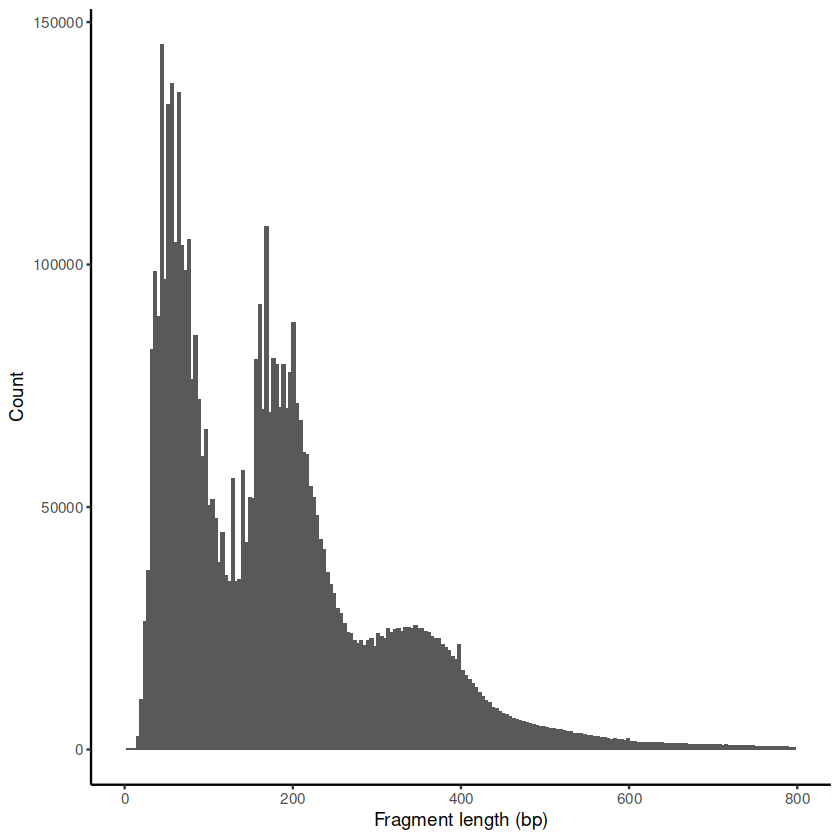

In [4]:
# define the filepath
dataset = "TDR126"
base_path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/"

dataset_processed <- gsub("reseq", "", dataset)
seurat_obj_path <- paste0(base_path, dataset, "/", dataset_processed, "_processed.RDS")

# Load the Seurat object
object <- readRDS(seurat_obj_path)

Idents(object) <- "orig.ident"

# NOTE that our gRanges object has the format of "1-start-end", not "chr1-start-end", so, we'd have to change the region argument
plot1 <- FragmentHistogram(object, region = "1-1-20000000")

print(plot1)

Warning message:
“Removed 17546 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 17546 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


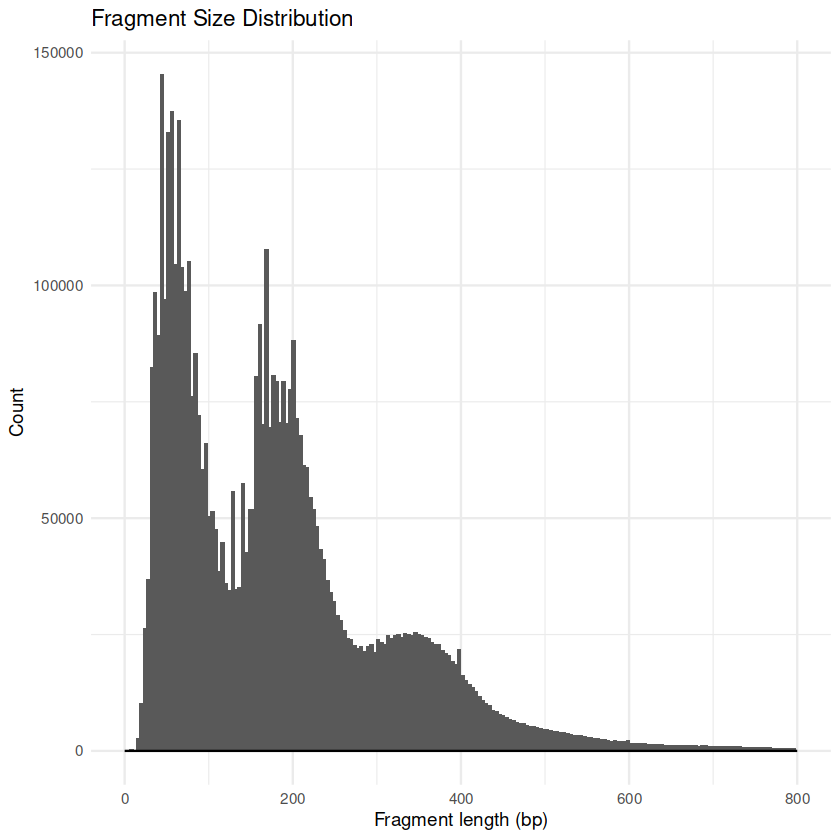

In [5]:
# Extract the ggplot object and modify it to remove fill color
plot1_modified <- plot1 +
  geom_density(aes(fill = NULL), position = "identity", alpha = 0.7, stat = "density") +
  theme_minimal() +
  labs(
    title = "Fragment Size Distribution",
    x = "Fragment length (bp)",
    y = "Count"
  ) +
  theme(legend.title = element_blank())

print(plot1_modified)

# ggsave(paste0(figpath, "hist_fragment_lengths_datasets_test.pdf"), plot = plot1_modified, width = 8, height = 12)


In [9]:
FragmentHistogram <- function(
  object,
  assay = NULL,
  region = "chr1-1-2000000",
  group.by = NULL,
  cells = NULL,
  log.scale = FALSE,
  ...
) {
  cells <- SetIfNull(x = cells, y = colnames(x = object))
  assay <- SetIfNull(x = assay, y = DefaultAssay(object = object))
  if (!inherits(x = object[[assay]], what = "ChromatinAssay")) {
    stop("The requested assay is not a ChromatinAssay.")
  }
  reads <- MultiGetReadsInRegion(
    object = object,
    assay = assay,
    region = region,
    cells = cells,
    verbose = FALSE,
    ...
  )
  # add group information
  if (is.null(x = group.by)) {
    groups <- Idents(object = object)
  } else {
    md <- object[[]]
    groups <- object[[group.by]]
    groups <- groups[, 1]
    names(x = groups) <- rownames(x = md)
  }
  reads$group <- groups[reads$cell]
  if (length(x = unique(x = reads$group)) == 1) {
    p <- ggplot(data = reads, aes(length)) +
      geom_density(aes(y = after_stat(density)), color = "black", fill = NA, linewidth = 1)  # Use geom_density instead of geom_histogram
  } else {
    p <- ggplot(data = reads, mapping = aes(x = length, color = group)) +
      geom_density(aes(y = after_stat(density)), fill = NA, linewidth = 1) +  # Use geom_density instead of geom_histogram
      facet_wrap(~group, scales = "free_y")
  }
  p <- p + xlim(c(0, 800)) +
    theme_classic() +
    theme(
      legend.position = "none",
      strip.background = element_blank()
    ) +
    xlab("Fragment length (bp)") +
    ylab("Density")  # Change y-axis label to "Density"
  if (log.scale) {
    p <- p + scale_y_log10()
  }
  return(p)
}

In [13]:
SetIfNull <- function(x, y) {
  if (is.null(x)) {
    return(y)
  } else {
    return(x)
  }
}

In [14]:
GetReadsInRegion <- function(cellmap, region, tabix.file, ...) {
  # Mock function to return a placeholder data.frame
  data.frame(
    length = runif(1000, min = 50, max = 800),
    cell = sample(cellmap, 1000, replace = TRUE)
  )
}

MultiGetReadsInRegion <- function(object, assay, region, cells, verbose, ...) {
  # Mock function to call GetReadsInRegion for each cell
  cellmap <- cells
  tabix.file <- "path/to/tabix/file"  # Replace with actual tabix file path if needed
  reads_list <- lapply(cells, function(cell) {
    GetReadsInRegion(cellmap = cellmap, region = region, tabix.file = tabix.file, ...)
  })
  do.call(rbind, reads_list)
}

In [11]:
# Load Rsamtools
library(Rsamtools)

Loading required package: GenomeInfoDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loa

In [12]:
GetIndexFile <- function(fragment, verbose = FALSE) {
  # Mock function to handle the indexing
  # Assuming the index file has the same name as the fragment file with a .tbi extension
  return(paste0(fragment, ".tbi"))
}

## Run FragmentHistogram (modified)

In [ ]:
# NOTE that our gRanges object has the format of "1-start-end", not "chr1-start-end", so, we'd have to change the region argument
plot1 <- FragmentHistogram(object, region = "1-1-20000000")

print(plot1)

Warning message:
“Removed 17546 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 17546 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


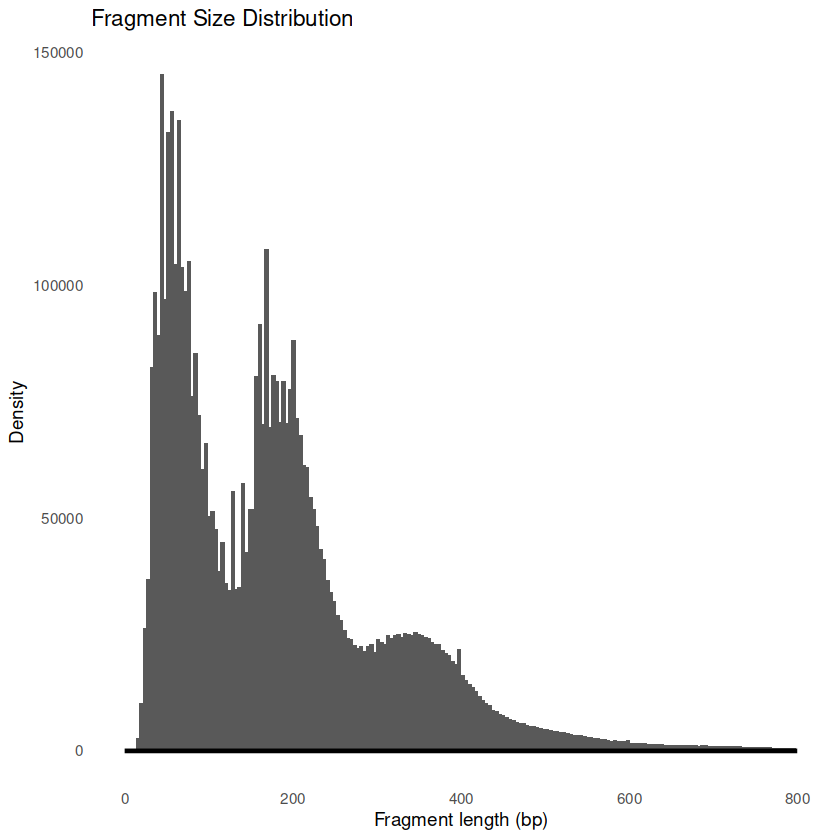

In [8]:
# Remove the existing histogram layer and add the density plot with no fill color
plot1_modified <- plot1 +
  geom_density(aes(x = length, y = after_stat(density)), color = "black", fill = NA, linewidth = 1) +
  theme_minimal() +
  labs(
    x = "Fragment length (bp)",
    y = "Density",
    title = "Fragment Size Distribution"
  ) +
  theme(
    legend.position = "none"
  )

# Remove existing histogram layers if they are present
plot1_modified <- plot1_modified + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Display the modified plot
print(plot1_modified)

In [ ]:
# # Define the list of dataset names and their corresponding paths
# dataset_names <- c("TDR126","TDR127","TDR128","TDR118reseq","TDR119reseq","TDR125reseq","TDR124reseq")
# base_path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/"
# # figpath <- "/path/to/your/figures/"  # Adjust the path as needed

# # Create a loop to process each dataset
# for (dataset in dataset_names) {
#     # Construct the full path to the Seurat object
#     # Remove "reseq" from the dataset name
#     dataset_processed <- gsub("reseq", "", dataset)
#     seurat_obj_path <- paste0(base_path, dataset, "/", dataset_processed, "_processed.RDS")

#     # Load the Seurat object
#     seurat_obj <- readRDS(seurat_obj_path)

#     # Run TSSEnrichment
#     seurat_obj <- TSSEnrichment(object = seurat_obj, fast = FALSE)

#     # Generate the TSS plot
#     tss.plot <- TSSPlot(seurat_obj)

#     # Print the TSS plot
#     print(tss.plot)

#     # Save the TSS plot
#     ggsave(paste0(figpath, "TSS_enrichment_", dataset_processed, ".pdf"), plot = tss.plot, width = 8, height = 6)

#     # Optionally, save the updated Seurat object if you want to keep the TSSEnrichment results
#     saveRDS(seurat_obj, paste0(base_path, dataset, "/", dataset_processed, "_processed_with_TSS.RDS"))
# }

## TSS enrichment vs distance from TSS

In [99]:
# compute TSS enrichment score per cell (need to re-run this as we merged the seurat objects from individual timepoints)
multiome <- TSSEnrichment(object = multiome, fast = FALSE)

Extracting TSS positions

Finding + strand cut sites



In [ ]:
multiome

In [98]:
TSSPlot(multiome, group.by = "dataset")

ERROR: Error in TSSPlot(multiome, group.by = "dataset"): Position enrichment matrix not present in assay


In [6]:
# TSSEnrichment takes 5-6 hours on HPC to compute, so let's just use individual datasets
seurat_obj <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR126/TDR126_processed_with_TSS.RDS")

seurat_obj <- TSSEnrichment(object=seurat_obj, fast = FALSE)
tss.plot <- TSSPlot(seurat_obj)

print(tss.plot)

ggsave(paste0(figpath, "TSS_enrichment_TDR118.pdf"), plot = tss.plot, width = 8, height = 6)

In [7]:
seurat_obj

An object of class Seurat 
1573599 features across 13614 samples within 7 assays 
Active assay: peaks_merged (485357 features, 485357 variable features)
 6 other assays present: RNA, ATAC, SCT, peaks_bulk, peaks_celltype, Gene.Activity
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.joint

In [13]:
seurat_obj <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR126/TDR126_processed_with_TSS.RDS")

Idents(seurat_obj) <- "orig.ident"

tss.plot <- TSSPlot(seurat_obj)
print(tss.plot)

ggsave(paste0(figpath, "TSS_enrichment_TDR126.pdf"), plot = tss.plot, width = 8, height = 6)

ERROR: Error in readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR126/TDR126_processed_with_TSS.RDS"): error reading from connection


In [8]:
DefaultAssay(seurat_obj) <- "ATAC"

In [9]:
tss.plot <- TSSPlot(seurat_obj)
tss.plot

ERROR: Error in TSSPlot(seurat_obj): Position enrichment matrix not present in assay


In [ ]:
# Define the list of dataset names and their corresponding paths
dataset_names <- c("TDR126","TDR127","TDR128","TDR118reseq","TDR119reseq","TDR125reseq","TDR124reseq")
base_path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/"
# figpath <- "/path/to/your/figures/"  # Adjust the path as needed

# Create a loop to process each dataset
for (dataset in dataset_names) {
    # Construct the full path to the Seurat object
    # Remove "reseq" from the dataset name
    dataset_processed <- gsub("reseq", "", dataset)
    seurat_obj_path <- paste0(base_path, dataset, "/", dataset_processed, "_processed.RDS")

    # Load the Seurat object
    seurat_obj <- readRDS(seurat_obj_path)

    # Run TSSEnrichment
    seurat_obj <- TSSEnrichment(object = seurat_obj, fast = FALSE)

    # Generate the TSS plot
    tss.plot <- TSSPlot(seurat_obj)

    # Print the TSS plot
    print(tss.plot)

    # Save the TSS plot
    ggsave(paste0(figpath, "TSS_enrichment_", dataset_processed, ".pdf"), plot = tss.plot, width = 8, height = 6)

    # Optionally, save the updated Seurat object if you want to keep the TSSEnrichment results
    saveRDS(seurat_obj, paste0(base_path, dataset, "/", dataset_processed, "_processed_with_TSS.RDS"))
}

In [10]:
# Define the list of dataset names and their corresponding paths
dataset_names <- c("TDR126")#,"TDR127","TDR128","TDR118reseq","TDR119reseq","TDR125reseq","TDR124reseq")
base_path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/"
# figpath <- "/path/to/your/figures/"  # Adjust the path as needed

# Create a loop to process each dataset
for (dataset in dataset_names) {
    # Construct the full path to the Seurat object
    # Remove "reseq" from the dataset name
    dataset_processed <- gsub("reseq", "", dataset)
    seurat_obj_path <- paste0(base_path, dataset, "/", dataset_processed, "_processed.RDS")

    # Load the Seurat object
    seurat_obj <- readRDS(seurat_obj_path)

    # Run TSSEnrichment
    seurat_obj <- TSSEnrichment(object = seurat_obj, fast = FALSE)

    # Generate the TSS plot
    tss.plot <- TSSPlot(seurat_obj)

    # Print the TSS plot
    print(tss.plot)

    # Save the TSS plot
    ggsave(paste0(figpath, "TSS_enrichment_", dataset_processed, ".pdf"), plot = tss.plot, width = 8, height = 6)

    # Optionally, save the updated Seurat object if you want to keep the TSSEnrichment results
    saveRDS(seurat_obj, paste0(base_path, dataset, "/", dataset_processed, "_processed_with_TSS.RDS"))
}

In [ ]:
multiome@meta.data$dataset

In [ ]:
# List of genes to plot
some_genes <- c('tbxta', 'sox2', 'myf5', 'pax6a', 'meox1')

# Extract relevant data from the Seurat object
df <- multiome@meta.data %>%
  select(cell = rownames(multiome@meta.data), time = dev_stage) %>%
  cbind(t(seurat_obj@assays[['RNA']][some_genes,])) %>%
  mutate(time2 = factor(time,
                        levels = sort(unique(time)),
                        labels = c("0-2", "1-3", "2-4", "3-7", "4-8", 
                                   "6-10", "8-12", "10-14", "12-16", "14-18", 
                                   "16-20")))

# Reshape data for plotting
df1 <- df %>%
  select(-cell, -time) %>%
  pivot_longer(cols = all_of(some_genes), names_to = "gene", values_to = "expression")

# Compute mean expression
df2 <- df1 %>%
  group_by(time2, gene) %>%
  summarize(count = sum(expression), n = n(), .groups = 'drop') %>%
  mutate(mean_expression = count / n)

# Create the plot
p <- df1 %>%
  ggplot(aes(x = time2, y = expression, color = time2, group = time2)) +
  geom_boxplot(outlier.shape = NA) +
  geom_line(aes(x = time2, y = mean_expression, color = time2, group = gene), data = df2) + 
  xlab('Time (hours)') + 
  ylab('Expression') +
  scale_color_manual("Time (hrs)", values = some_colors) +
  guides(color = 'none') +
  facet_wrap(~ gene, ncol = 1, strip.position = "right", scales = 'free_y') +
  theme(strip.background = element_blank(), strip.text = element_text(size = 14),
        axis.text = element_text(size = 8))

# Save the plot
ggsave('figures/time_expression_boxplot.pdf', p, height = 6, width = 5.5)
